In [1]:
# import libraries
import math

import numpy as np

import scipy
from scipy.io import loadmat  # for loading matlab files

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import GridSearchCV

In [2]:
# Data Preparation

# training data loading - input and output

x_train = loadmat('x_train.mat')
x_train = np.array(x_train['x_train'])
print(type(x_train),x_train.shape)

y_train = loadmat('y_train.mat')
y_train = np.array(y_train['y_train'])
print(type(y_train),y_train.shape)

# test data loading - input and ground truth output, predicted output is to be generated by GPR model

x_test = loadmat('x_test.mat')
x_test = np.array(x_test['x_test'])
# x_test = np.reshape(x_test[:,1],(-1,1)) # only the second column is extracted for simplicity
print(type(x_test),x_test.shape)

y_testtrue = loadmat('y_testtrue.mat')
y_testtrue = np.array(y_testtrue['y'])
# y_testtrue = np.reshape(y_testtrue[:,0],(-1,1))
print(type(y_testtrue),y_testtrue.shape)

<class 'numpy.ndarray'> (215, 2)
<class 'numpy.ndarray'> (215, 1)
<class 'numpy.ndarray'> (147, 2)
<class 'numpy.ndarray'> (147, 1)


In [3]:
# truncate data for limited resources
OFFSET = 0
NUM_TRAIN = 30
NUM_PRED = 10

# take the first NUM_TRAIN samples for training
x_train = x_train[OFFSET:NUM_TRAIN + OFFSET]
y_train = y_train[OFFSET:NUM_TRAIN + OFFSET]

# print the size of the training data
print('x_train size:',x_train.shape)
print('y_train size:',y_train.shape)

# take the first NUM_PRED samples for prediction
x_test = x_test[:NUM_PRED]
y_testtrue = y_testtrue[:NUM_PRED]

# print the size of the test data
print('x_test size:',x_test.shape)
print('y_testtrue size:',y_testtrue.shape)

x_train size: (30, 2)
y_train size: (30, 1)
x_test size: (10, 2)
y_testtrue size: (10, 1)


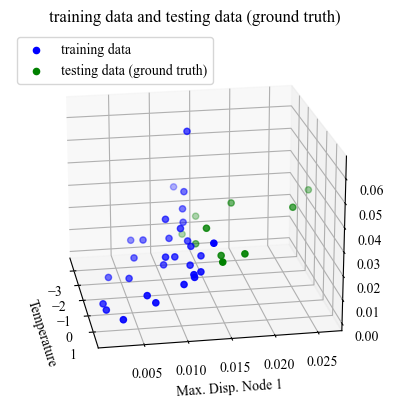

In [4]:
# visualize the data 

fig_dc = plt.figure()
ax_dc = fig_dc.add_subplot(111, projection = '3d')

# plot the data
ax_dc.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'blue',label = 'training data')
ax_dc.scatter(x_test[:, 0], x_test[:, 1], y_testtrue, c = 'green',label = 'testing data (ground truth)')

# set the limits for the plots
# ax_dc.set_xlim(-3, 3)
# ax_dc.set_ylim(0, 0.03)
# ax_dc.set_zlim(0, 0.1)

# set the labels and titles for the plots
ax_dc.set_xlabel('Temperature')
ax_dc.set_ylabel('Max. Disp. Node 1')
ax_dc.set_zlabel('y')
ax_dc.set_title('training data and testing data (ground truth)')

# add legends for the plots
plt.legend(loc = 'upper left')

# view
ax_dc.view_init(20, -10)

# Show the plot
plt.show()

the data is from the embedded devices

In [5]:
# generated data for prediction
y_testpred = [0.023515,    0.059442,    0.024874,    0.029602,    0.047086,    0.034630,    0.027722,    0.032192,    0.026660,    0.023718]

std_testpred = [0.026465,    0.026571,    0.027057,    0.024270,    0.025486,    0.041940,    0.042055,    0.044106,    0.039703,    0.041019]

y_testpred_ub = [y_testpred[i] + 2*std_testpred[i] for i in range(NUM_PRED)]

y_testpred_lb = [y_testpred[i] - 2*std_testpred[i] for i in range(NUM_PRED)]

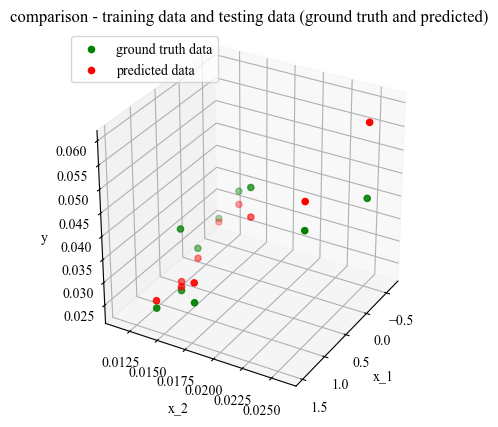

In [6]:
# check generated data for testing
fig_gpr = plt.figure()
ax_gpr = fig_gpr.add_subplot(111, projection='3d')
# ax_gpr.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'blue',label = 'training data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testtrue, c = 'green',label = 'ground truth data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred, c = 'red',label = 'predicted data')

# # set the limits for the plots
# ax_gpr.set_xlim(-5, 5)
# ax_gpr.set_ylim(0, 0.05)
# ax_gpr.set_zlim(0, 0.05)

# set the labels and titles for the plots
ax_gpr.set_xlabel('x_1')
ax_gpr.set_ylabel('x_2')
ax_gpr.set_zlabel('y')
ax_gpr.set_title('comparison - training data and testing data (ground truth and predicted)')

# add legends for the plots
plt.legend(loc = 'upper left')

# view
ax_gpr.view_init(30, 30)
# ax_gpr.view_init(90, 0)

# perspective mode setup
ax_gpr.set_box_aspect([1,1,1])

# Show the plot
plt.show()

# print(max(y_testpred))

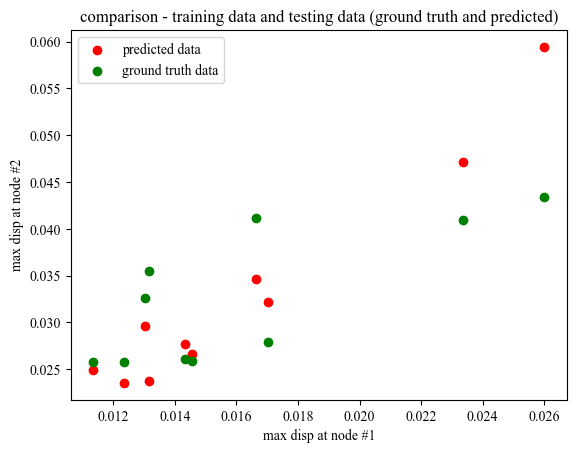

In [7]:
# 2D analysis - recall that the physical meaning is to use one pier max disp to predict the other

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# ax_gpr2d.scatter(x_train[:,1], y_train, c = 'blue',label = 'training data')
ax_gpr2d.scatter(x_test[:,1], y_testpred, c = 'red',label = 'predicted data')
ax_gpr2d.scatter(x_test[:,1], y_testtrue, c = 'green',label = 'ground truth data')

# set the labels and titles for the plots
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted)')

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()

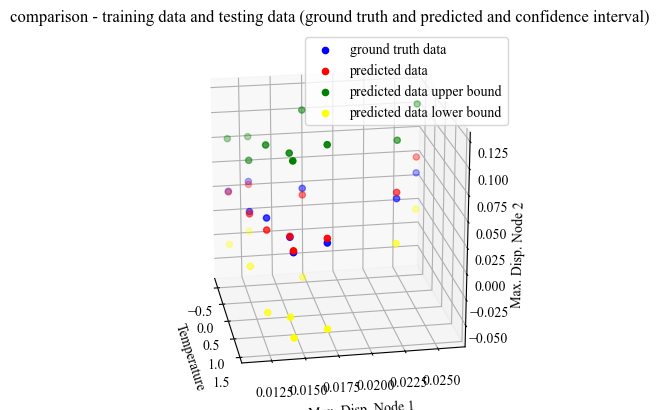

In [8]:
# visualize the data and confidence interval - 3D

# check generated data for testing
fig_gpr = plt.figure()
ax_gpr = fig_gpr.add_subplot(111, projection='3d')
# ax_gpr.scatter(x_train[:, 0], x_train[:, 1], y_train, c = 'black',label = 'training data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testtrue, c = 'blue',label = 'ground truth data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred, c = 'red',label = 'predicted data')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred_ub, c = 'green',label = 'predicted data upper bound')
ax_gpr.scatter(x_test[:, 0], x_test[:, 1], y_testpred_lb, c = 'yellow',label = 'predicted data lower bound')


# # set the limits for the plots
# ax_gpr.set_xlim(-5, 5)
# ax_gpr.set_ylim(0, 0.05)
# ax_gpr.set_zlim(0, 0.05)

# set the labels and titles for the plots
ax_gpr.set_xlabel('Temperature')
ax_gpr.set_ylabel('Max. Disp. Node 1')
ax_gpr.set_zlabel('Max. Disp. Node 2')
ax_gpr.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# add legends for the plots
plt.legend(loc = 'best')

# view
# ax_gpr.view_init(30, 30)
ax_gpr.view_init(20, -10)

# perspective mode setup
ax_gpr.set_box_aspect([1,1,1])

# Show the plot
plt.show()

# print(max(y_testpred))

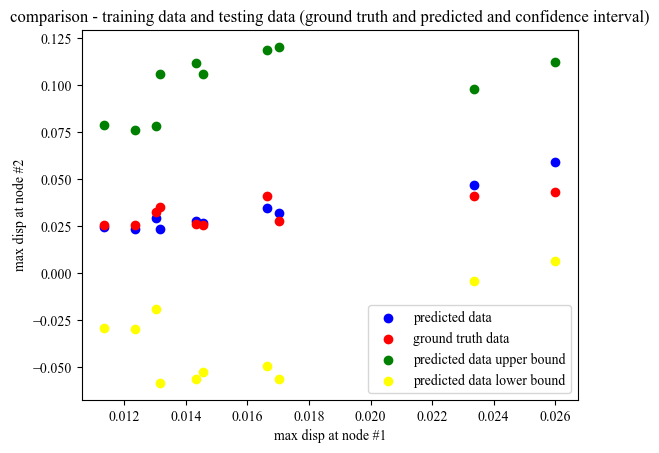

In [9]:
# 2D analysis - recall that the physical meaning is to use one pier max disp to predict the other

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# ax_gpr2d.scatter(x_train[:,1], y_train, c = 'black',label = 'training data')
ax_gpr2d.scatter(x_test[:,1], y_testpred, c = 'blue',label = 'predicted data')
ax_gpr2d.scatter(x_test[:,1], y_testtrue, c = 'red',label = 'ground truth data')
ax_gpr2d.scatter(x_test[:,1], y_testpred_ub, c = 'green',label = 'predicted data upper bound')
ax_gpr2d.scatter(x_test[:,1], y_testpred_lb, c = 'yellow',label = 'predicted data lower bound')

# # fill the confidence interval
# fill_x = np.concatenate([x_test[:,1], x_test[:,1]],axis = 0)
# fill_y = np.concatenate([y_testpred_ub[:,0], y_testpred_lb[:,0]],axis = 0)
# fill_x, fill_y = zip(*sorted(zip(fill_x, fill_y)))
# tri = Delaunay(np.array([fill_x, fill_y]).T)
# plt.triplot(fill_x, fill_y, tri.simplices, color='blue', alpha=0.2)
# plt.fill(fill_x, fill_y, color='purple', alpha=0.2)

# set the labels and titles for the plots
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()




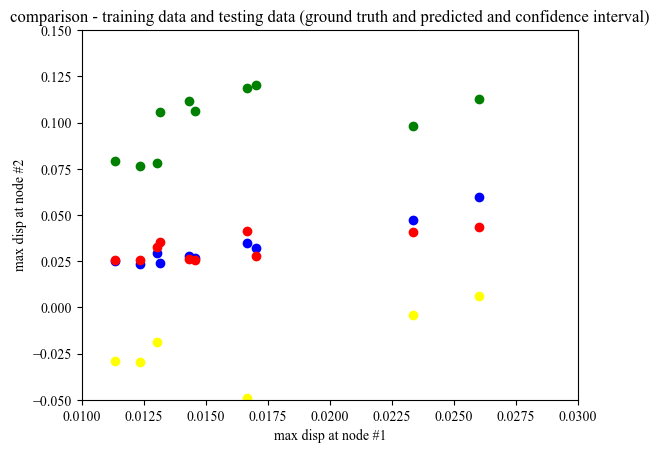

In [10]:
import matplotlib.pyplot as plt

fig_gpr2d = plt.figure()
ax_gpr2d = fig_gpr2d.add_subplot(111)

# 数据点的散点图
ax_gpr2d.scatter(x_test[:,1], y_testpred, c='blue', label='predicted data')
ax_gpr2d.scatter(x_test[:,1], y_testtrue, c='red', label='ground truth data')
ax_gpr2d.scatter(x_test[:,1], y_testpred_ub, c='green', label='predicted data upper bound')
ax_gpr2d.scatter(x_test[:,1], y_testpred_lb, c='yellow', label='predicted data lower bound')

# 设置坐标轴范围
x_min = 0.01  # 用户定义的 x 轴最小值
x_max = 0.03  # 用户定义的 x 轴最大值
y_min = -0.05  # 用户定义的 y 轴最小值
y_max = 0.15  # 用户定义的 y 轴最大值
ax_gpr2d.set_xlim(x_min, x_max)
ax_gpr2d.set_ylim(y_min, y_max)

# 设置标签和标题
ax_gpr2d.set_xlabel('max disp at node #1')
ax_gpr2d.set_ylabel('max disp at node #2')
ax_gpr2d.set_title('comparison - training data and testing data (ground truth and predicted and confidence interval)')

# 添加图例
# plt.legend(loc='best')

# 显示图像
plt.show()


upper limit:  0.0677344
lower limit:  -0.0677344


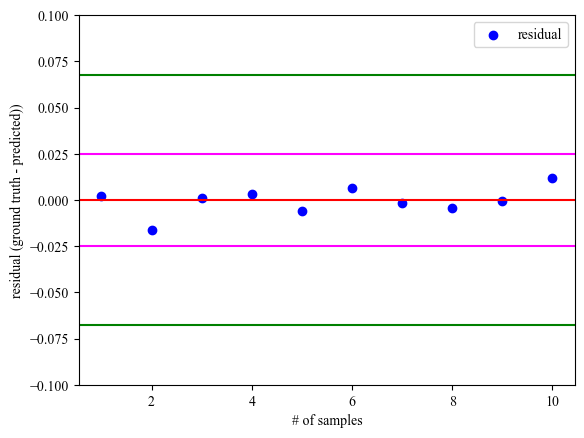

In [11]:
# SPC

# convert y_testpred, y_testtrue to numpy array
y_testpred = np.array(y_testpred).reshape(-1,1)
y_testtrue = np.array(y_testtrue).reshape(-1,1)

y_res = y_testtrue - y_testpred

# visualize the residual - 2D
fig_spc2d = plt.figure()
ax_spc2d = fig_spc2d.add_subplot(111)

SampleNumber = np.linspace(1,len(y_res),len(y_res))

ax_spc2d.scatter(SampleNumber, y_res, c = 'blue',label = 'residual')

# set the labels and titles for the plots
ax_spc2d.set_xlabel('# of samples')
ax_spc2d.set_ylabel('residual (ground truth - predicted))')

# set the limits for the plots

# xmin_res = min(x_test[:,1])
# xmax_res = max(x_test[:,1])
ymin_res = min(y_res)
ymax_res = max(y_res)
ymark = max(abs(ymin_res), abs(ymax_res))

# ax_spc2d.set_xlim(-1.1*xmin_res, 1.1*xmax_res)
# ax_spc2d.set_ylim(-3*ymark, 3*ymark)

ax_spc2d.set_ylim(-0.1, 0.1)

# 0 line
plt.axhline(0, color='red')  # Draw the line at y = 0

# control limit
# upper_limit = max(2 * np.mean(std_testpred),max(y_res))
# lower_limit = min(2 * np.mean(std_testpred),min(y_res))

upper_limit = 2 * np.mean(std_testpred)
lower_limit = -2 * np.mean(std_testpred)
plt.axhline(upper_limit, color='green') # Draw the line at y = upper_limit
plt.axhline(lower_limit, color='green') # Draw the line at y = lower_limit

print('upper limit: ', upper_limit)
print('lower limit: ', lower_limit)

# standard deviation from the training data
std_train = np.std(y_train)
tul = 2.0 * std_train
tll = -2.0 * std_train
plt.axhline(tul, color='magenta') # Draw the line at y = upper_limit
plt.axhline(tll, color='magenta') # Draw the line at y = lower_limit

# add legends for the plots
plt.legend(loc = 'best')

# Show the plot
plt.show()

